# MODIS Water Exploratory Data Analysis

Used for EDA of the training data generated into tabular formats.

Version: 09.07.2021

In [17]:
import csv
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

warnings.filterwarnings('ignore')
%matplotlib inline

In [26]:
TEST_RATIO = 0.2

#Tile is 'Global' for v3.0.0 instead of 'Golden'
TILE = 'GLOBAL'
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [36]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [28]:
glob_string = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v3.0.0/*{}*.parquet.gzip'.format(TILE)
data_paths = sorted([fv for fv in glob.glob(glob_string)])
pprint(data_paths)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v3.0.0/MOD09_GLOBAL_5599995_3_0_2.parquet.gzip']


In [21]:
data_idx = 0
data_path = data_paths[data_idx]
os.path.exists(data_path)

True

## Load in data for use of visualizations 
(skip this if you just want to train model)

In [42]:
%%time

#Does not split data into train and test. 
df = load_data(fpath=data_path, 
               colsToDrop=colsToDrop, 
               splitXY=False, 
               trainTestSplit=False, 
               imbalance=True,
               multi=False,
              frac=0.5)

CPU times: user 6.07 s, sys: 1.17 s, total: 7.24 s
Wall time: 6.7 s


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5471295 entries, 0 to 5499999
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   water           float32
 1   sur_refl_b01_1  float32
 2   sur_refl_b02_1  float32
 3   sur_refl_b03_1  float32
 4   sur_refl_b04_1  float32
 5   sur_refl_b05_1  float32
 6   sur_refl_b06_1  float32
 7   sur_refl_b07_1  float32
 8   ndvi            float32
 9   ndwi1           float32
 10  ndwi2           float32
dtypes: float32(11)
memory usage: 271.3 MB


In [31]:
########################
# See how many 0, 1 there are in the dataset

num_land = np.count_nonzero(df['water']) #How many land points
num_water = len(df['water'])-num_land #how many water points


print(num_land,num_water)

2558336 2912959


In [32]:
#df.describe().T.to_csv('output/{}_outputInfo.csv'.format(TILE))
df.describe().T

,count,mean,std,min,25%,50%,75%,max
water,5471295.0,0.467592,0.498949,0.0,0.000000,0.000000,1.000000,1.0
sur_refl_b01_1,5471295.0,841.851257,990.548767,-100.0,162.000000,644.000000,1073.000000,13141.0
sur_refl_b02_1,5471295.0,1652.851074,1324.888794,-100.0,169.000000,1877.000000,2569.000000,12205.0
sur_refl_b03_1,5471295.0,512.695129,695.314392,-100.0,178.000000,343.000000,571.000000,9119.0
sur_refl_b04_1,5471295.0,736.332275,799.820557,-100.0,274.000000,612.000000,878.000000,9550.0
sur_refl_b05_1,5471295.0,1890.366943,1472.163086,-100.0,146.000000,2263.000000,3108.000000,9383.0
sur_refl_b06_1,5471295.0,1638.656250,1387.571289,-100.0,160.000000,1591.000000,2660.000000,7855.0
sur_refl_b07_1,5471295.0,1081.531372,1091.515991,-100.0,71.000000,808.000000,1705.000000,9357.0
ndvi,5471295.0,264.894470,12030.812500,-1990000.0,-1945.465820,2476.531006,4992.291016,2010000.0
ndwi1,5471295.0,-2181.238525,11623.588867,-2010000.0,-2929.623535,-884.635254,750.436279,1990000.0


In [11]:
# Get a sample so we can speed up expensive visualizations
sampledDf = df.sample(frac=0.1)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547130 entries, 4684394 to 5148966
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   water           547130 non-null  float32
 1   sur_refl_b01_1  547130 non-null  float32
 2   sur_refl_b02_1  547130 non-null  float32
 3   sur_refl_b03_1  547130 non-null  float32
 4   sur_refl_b04_1  547130 non-null  float32
 5   sur_refl_b05_1  547130 non-null  float32
 6   sur_refl_b06_1  547130 non-null  float32
 7   sur_refl_b07_1  547130 non-null  float32
 8   ndvi            547130 non-null  float32
 9   ndwi1           547130 non-null  float32
 10  ndwi2           547130 non-null  float32
dtypes: float32(11)
memory usage: 27.1 MB


In [12]:
df.sample(n=5)

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
3306157,1.0,-69.0,33.0,-100.0,-100.0,0.0,21.0,25.0,-28333.333984,2222.222168,1379.310303
4542302,0.0,828.0,3009.0,405.0,830.0,3501.0,3092.0,2222.0,5684.128418,-136.043274,1504.492432
971726,1.0,2789.0,2633.0,1616.0,2713.0,524.0,514.0,177.0,-287.716705,6733.396973,8740.213867
137512,1.0,905.0,321.0,602.0,929.0,152.0,173.0,90.0,-4763.458496,2995.951416,5620.437988
2621487,0.0,1116.0,2040.0,492.0,782.0,2961.0,3091.0,2188.0,2927.756592,-2048.333740,-350.047302


### Coorelation plots with water points as orange
#### This will take more than 15 mins to run.

In [13]:
# sns.set()
# sns.pairplot(sampledDf, hue='water', kind='reg')
# plt.savefig('output/{}_modisWaterTrainingEDA_Correlation_WaterHighlight.png'.format(TILE))

### Distribution for each channel

array([[<AxesSubplot: title={'center': 'water'}>,
        <AxesSubplot: title={'center': 'sur_refl_b01_1'}>,
        <AxesSubplot: title={'center': 'sur_refl_b02_1'}>],
       [<AxesSubplot: title={'center': 'sur_refl_b03_1'}>,
        <AxesSubplot: title={'center': 'sur_refl_b04_1'}>,
        <AxesSubplot: title={'center': 'sur_refl_b05_1'}>],
       [<AxesSubplot: title={'center': 'sur_refl_b06_1'}>,
        <AxesSubplot: title={'center': 'sur_refl_b07_1'}>,
        <AxesSubplot: title={'center': 'ndvi'}>],
       [<AxesSubplot: title={'center': 'ndwi1'}>,
        <AxesSubplot: title={'center': 'ndwi2'}>, <AxesSubplot: >]],
      dtype=object)

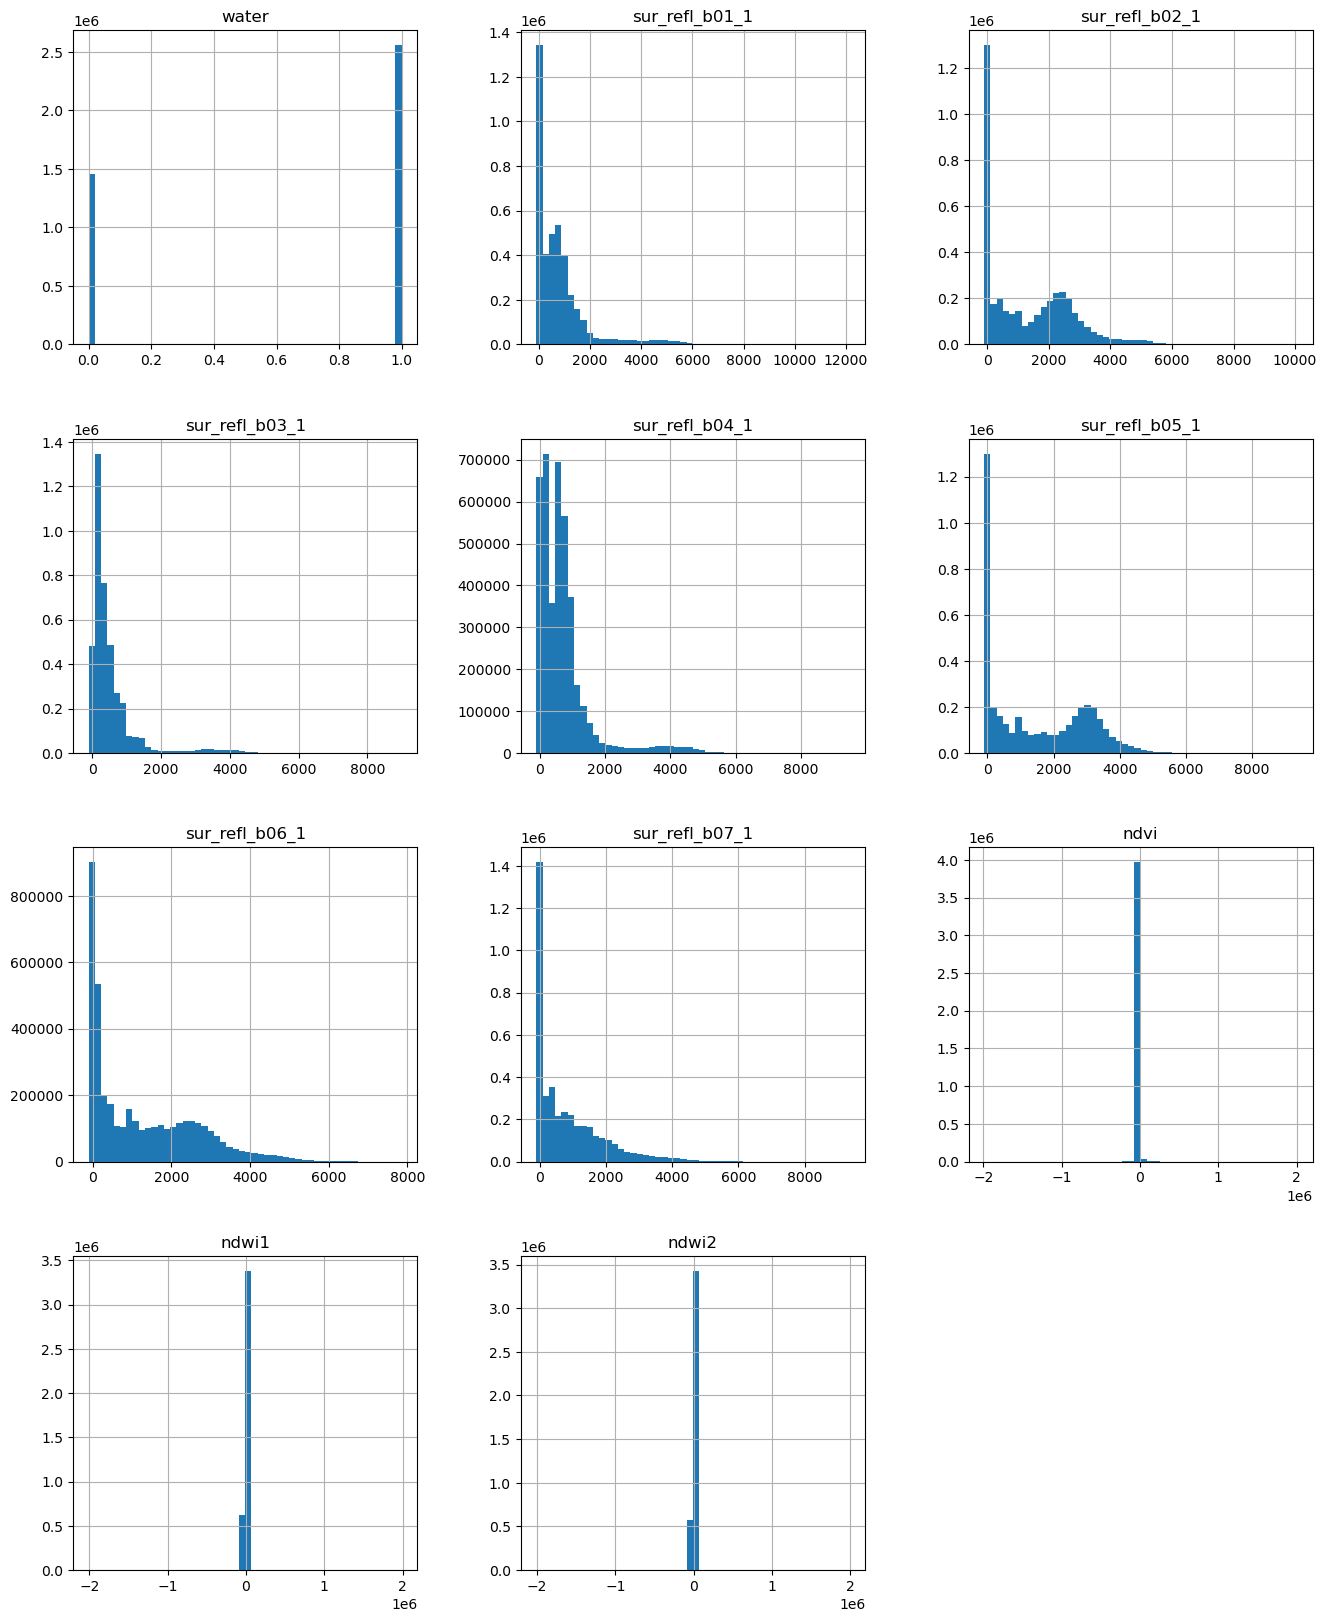

In [43]:
df.hist(figsize=(16, 20), bins=50)

Key takeaways from the historgram, theres more water than there is land points by about 400,000 points. Where are they though? My thought is that maybe we sample the water and the surrounding land as well as random points of land. Otherwise the other reflectance distributions looks very much gamma like. The ndwi,1,2 are all very mcuh centered around 0 so more normally distributed.

### Correlation calculations

In [15]:
# correlation with dataset - target valueI 
corr = df.corr()['water']
#corr.to_csv('output/{}_correlation.csv'.format(TILE))
corr

water             1.000000
sur_refl_b01_1   -0.191414
sur_refl_b02_1   -0.697125
sur_refl_b03_1    0.033941
sur_refl_b04_1   -0.124400
sur_refl_b05_1   -0.844615
sur_refl_b06_1   -0.797348
sur_refl_b07_1   -0.678398
ndvi             -0.383727
ndwi1            -0.186216
ndwi2            -0.195261
Name: water, dtype: float64

In [16]:
# full correlation table
df.corr().style.background_gradient(cmap='viridis')

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
water,1.000000,-0.191414,-0.697125,0.033941,-0.124400,-0.844615,-0.797348,-0.678398,-0.383727,-0.186216,-0.195261
sur_refl_b01_1,-0.191414,1.000000,0.703832,0.911524,0.966200,0.474219,0.479988,0.494278,0.126306,0.229049,0.192371
sur_refl_b02_1,-0.697125,0.703832,1.000000,0.540991,0.677002,0.876405,0.757777,0.636516,0.372908,0.303277,0.294705
sur_refl_b03_1,0.033941,0.911524,0.540991,1.000000,0.970417,0.232843,0.202665,0.214195,0.061893,0.203328,0.165273
sur_refl_b04_1,-0.124400,0.966200,0.677002,0.970417,1.000000,0.407438,0.374822,0.370287,0.129362,0.243515,0.208678
sur_refl_b05_1,-0.844615,0.474219,0.876405,0.232843,0.407438,1.000000,0.945078,0.832203,0.397354,0.230204,0.233744
sur_refl_b06_1,-0.797348,0.479988,0.757777,0.202665,0.374822,0.945078,1.000000,0.960262,0.325923,0.164370,0.154938
sur_refl_b07_1,-0.678398,0.494278,0.636516,0.214195,0.370287,0.832203,0.960262,1.000000,0.244648,0.113952,0.089978
ndvi,-0.383727,0.126306,0.372908,0.061893,0.129362,0.397354,0.325923,0.244648,1.000000,0.182177,0.199461
ndwi1,-0.186216,0.229049,0.303277,0.203328,0.243515,0.230204,0.164370,0.113952,0.182177,1.000000,0.210795


## Distributions

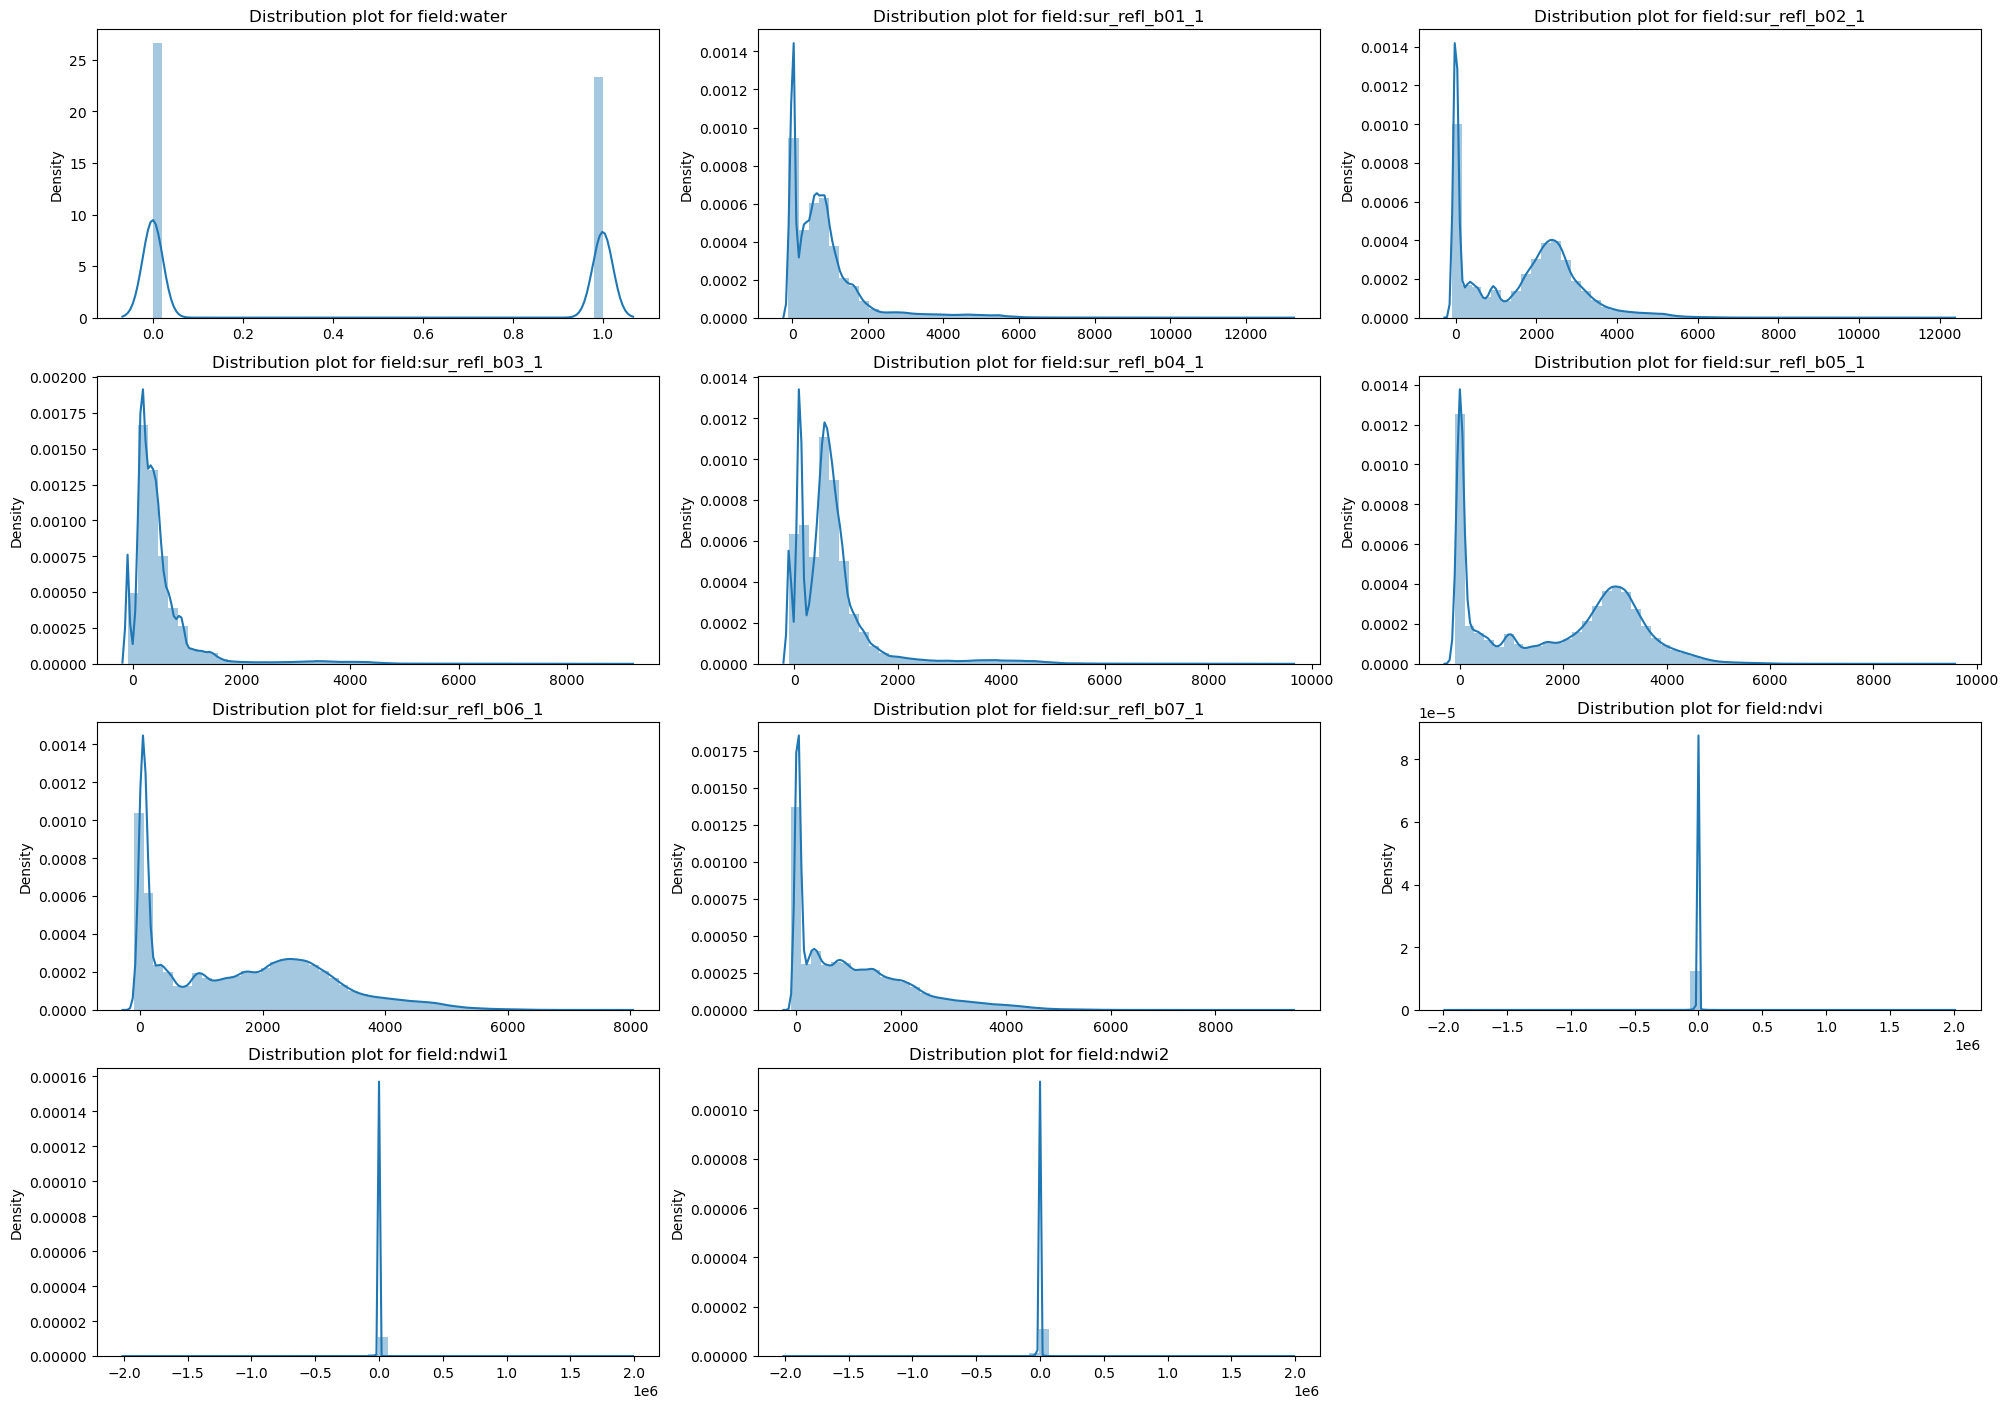

In [17]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(4,3,i+1)
    sns.distplot(df[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig('output/{}_output_dist_modis_water.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

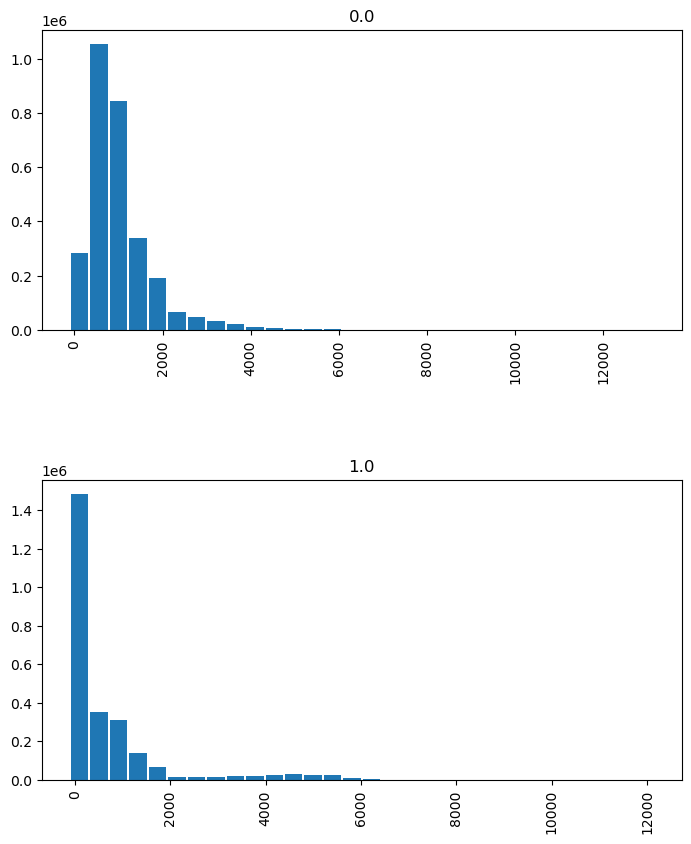

In [18]:
df.hist(column='sur_refl_b01_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b01_dist.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

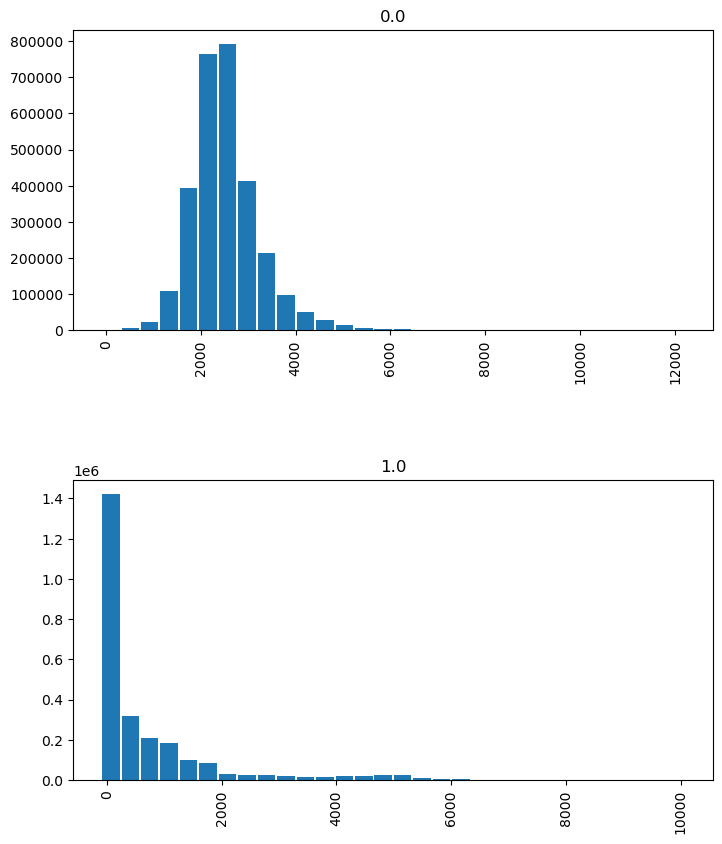

In [19]:
df.hist(column='sur_refl_b02_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b02_dist.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

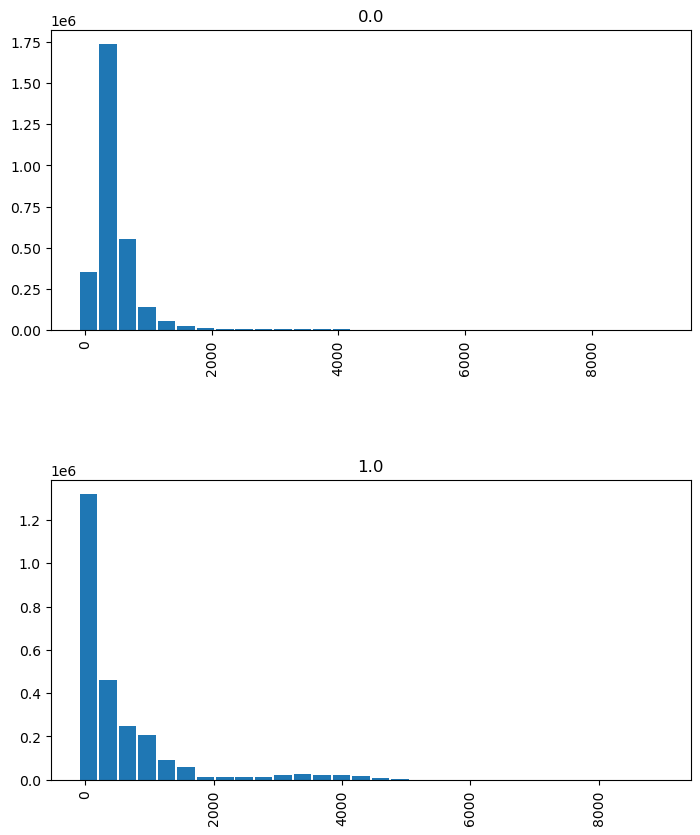

In [20]:
df.hist(column='sur_refl_b03_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b03_dist.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

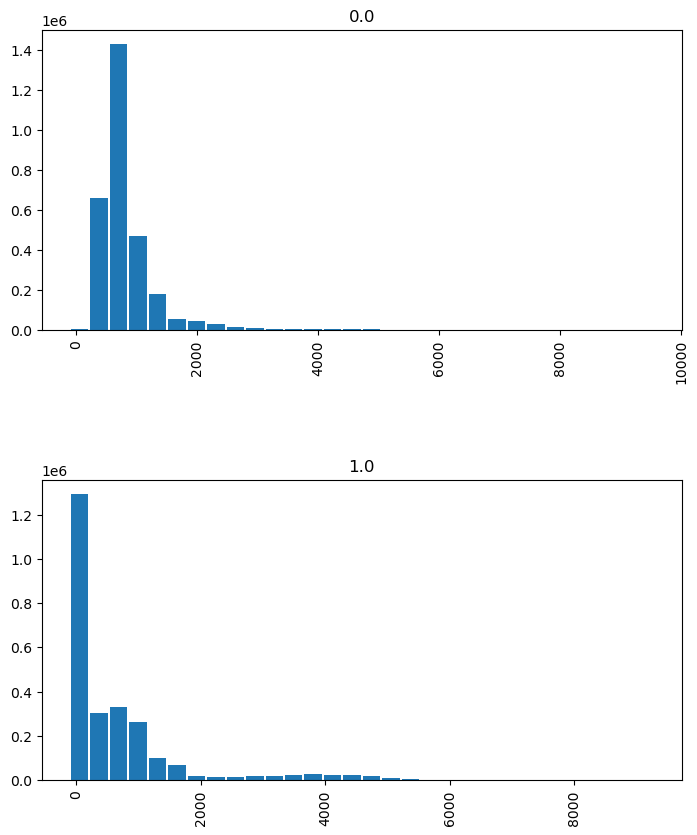

In [21]:
df.hist(column='sur_refl_b04_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b04_dist.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

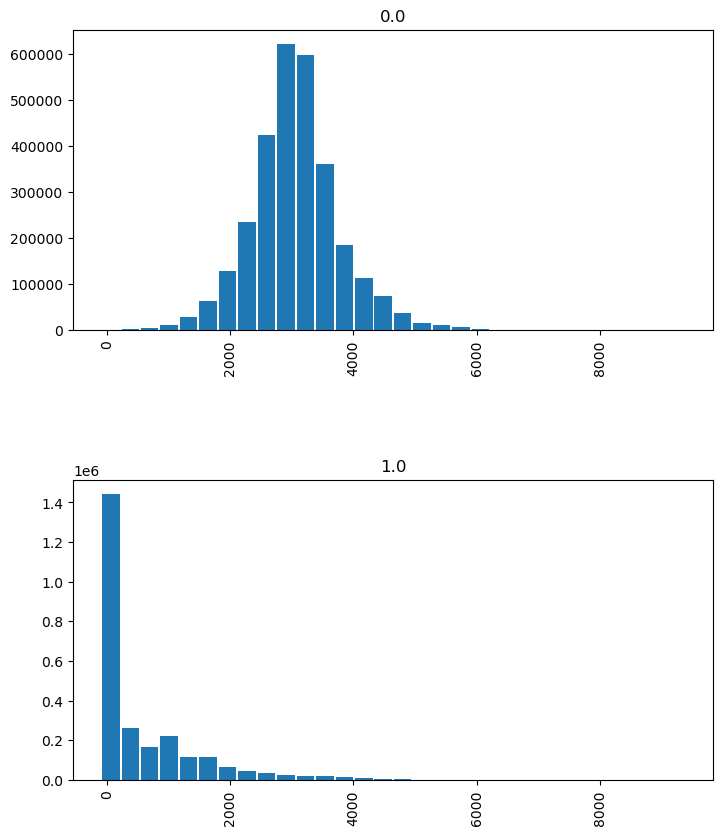

In [22]:
df.hist(column='sur_refl_b05_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b05_dist.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

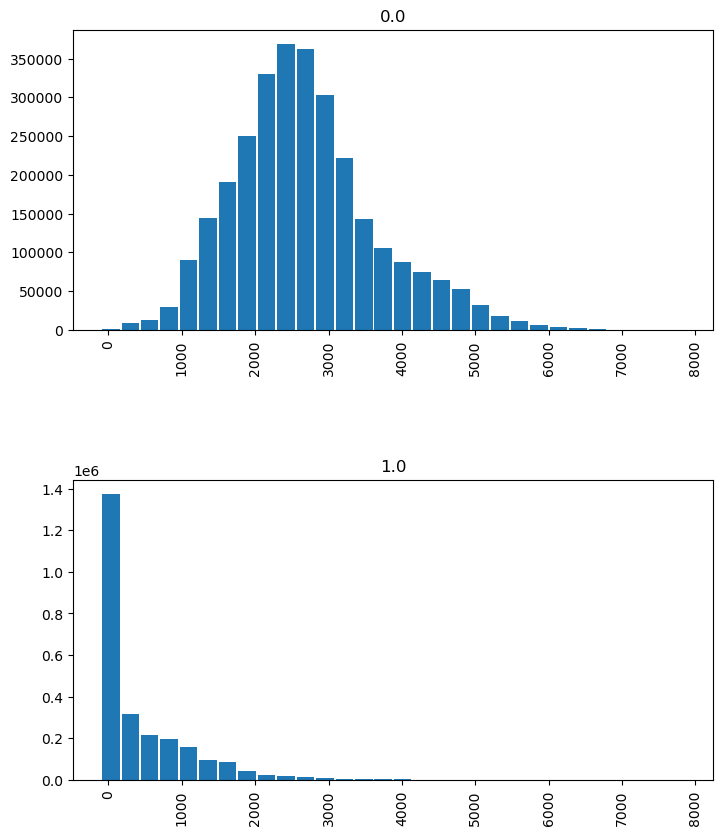

In [23]:
df.hist(column='sur_refl_b06_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b06_dist.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

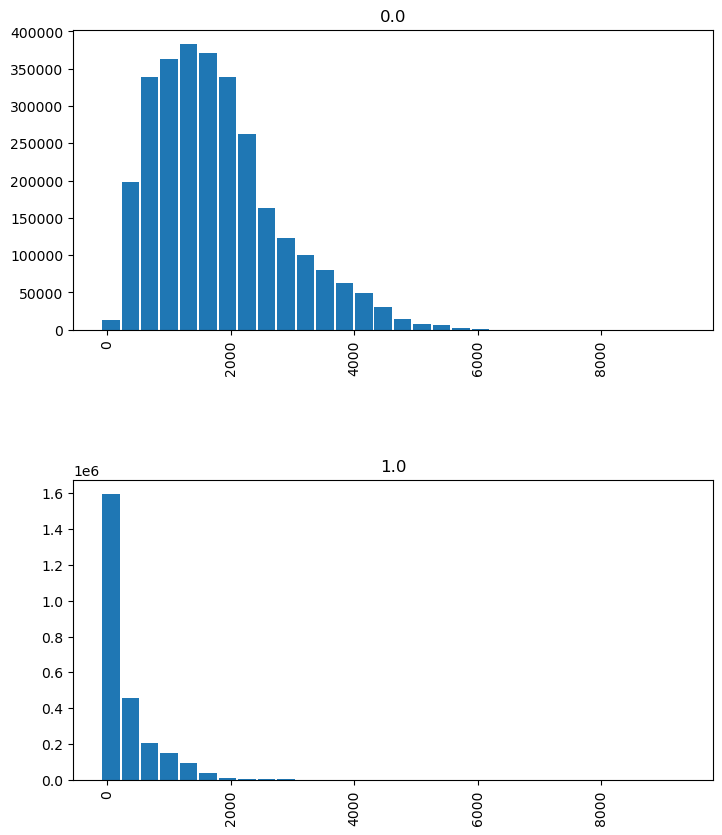

In [24]:
df.hist(column='sur_refl_b07_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b07_dist.png'.format(TILE))

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

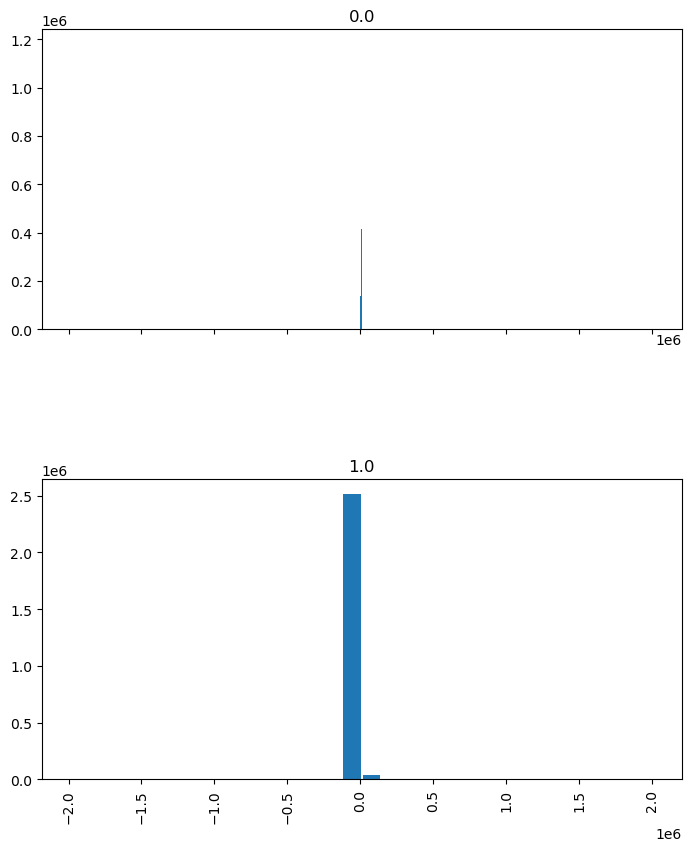

In [25]:
df.hist(column='ndvi', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=True)

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

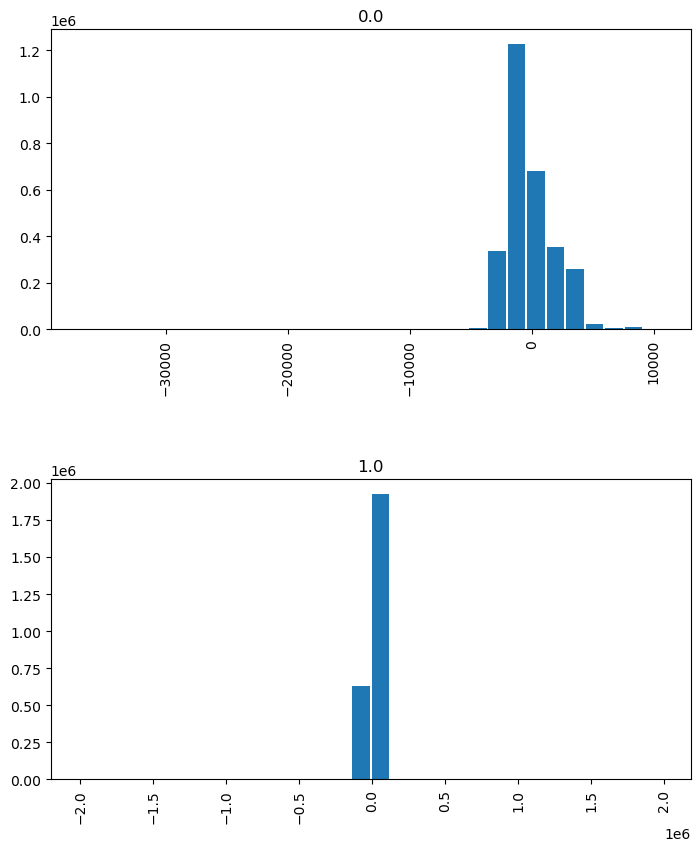

In [26]:
df.hist(column='ndwi1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

array([<AxesSubplot: title={'center': '0.0'}>,
       <AxesSubplot: title={'center': '1.0'}>], dtype=object)

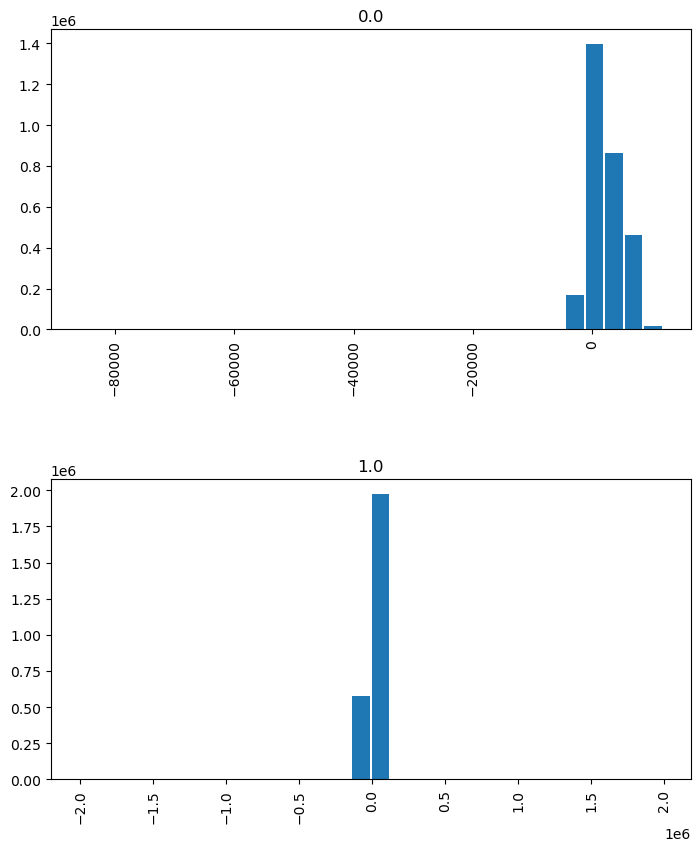

In [27]:
df.hist(column='ndwi2', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)